In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import io
import pandas as pd

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install rasterio

import rasterio as rio

In [ ]:
import glob
images = glob.glob('/content/drive/My Drive/IsfahanHeight' + '/*.tif')

In [ ]:
images = images[100:200]

In [ ]:
num_imgs = len(images)
print('num_imgs:',num_imgs)

num_imgs: 100


In [ ]:
img_multi = rio.open(images[1])
img_array = img_multi.read()

In [ ]:
imtransform = img_multi.transform
print('imtransform', imtransform)

imtransform | 0.00, 0.00, 51.88|
| 0.00,-0.00, 32.89|
| 0.00, 0.00, 1.00|


In [ ]:
nRows =  img_array.shape[1]
nCols =  img_array.shape[2]
Bands = img_array.shape[0]

In [ ]:
img_array_reshape = img_array.reshape(Bands, nRows*nCols).T
img_array_reshape = img_array_reshape.reshape(nRows,nCols,Bands)
print(img_array_reshape.shape)

(224, 224, 5)


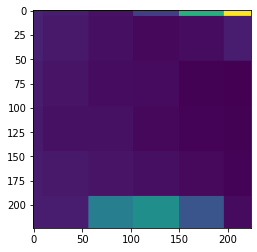

In [ ]:
plt.imshow(img_array[4,:,:].astype('float32'))
plt.show()

In [ ]:
print(img_array_reshape.reshape(1,nRows,nCols,Bands).shape)

(1, 224, 224, 5)


# Write tfrecord file

In [ ]:
import tensorflow as tf

In [ ]:
def write_tfrecords(images, filename):
    writer = tf.io.TFRecordWriter(filename)
    for filename in images:
        img_multi = rio.open(filename)
        img_array = img_multi.read()
        nRows_temp =  img_array.shape[1]
        nCols_temp =  img_array.shape[2]
        Bands = img_array.shape[0]
        img_array = img_array.reshape(Bands, nRows*nCols).T
        img_array = img_array.reshape(nRows,nCols,Bands)
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array[:,:,:4].tobytes()])),
                'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array[:,:,4].tobytes()])),
            }))
        writer.write(example.SerializeToString())

In [ ]:
write_tfrecords(images, '/content/drive/My Drive/IsfahanHeight/02_Isfahan.tfrecords')

# Read tfrecords

In [ ]:
image_feature_description = {
  'image': tf.io.FixedLenFeature([], tf.string),
  'label': tf.io.FixedLenFeature([], tf.string),
  }

In [ ]:
def _parse_image_function(example_proto):
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_raw(features['image'], tf.float32)
    image.set_shape([4 * 224 * 224])
    image = tf.reshape(image, [224, 224,4])

    label = tf.io.decode_raw(features['label'], tf.float32)
    label.set_shape([1 * 224 * 224])
    label = tf.reshape(label, [ 224, 224,1])

    return image, label

In [ ]:
def read_dataset(epochs, batch_size, filenames):

    dataset = tf.data.TFRecordDataset(filenames)

    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }

    dataset = dataset.map(_parse_image_function, num_parallel_calls=1)
    dataset = dataset.prefetch(1)
    dataset = dataset.repeat(epochs)
    dataset = dataset.shuffle(buffer_size=1 * batch_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)

    return dataset

In [ ]:
train_dataset = read_dataset(1, 100, '/content/drive/My Drive/IsfahanHeight/04_Isfahan.tfrecords')

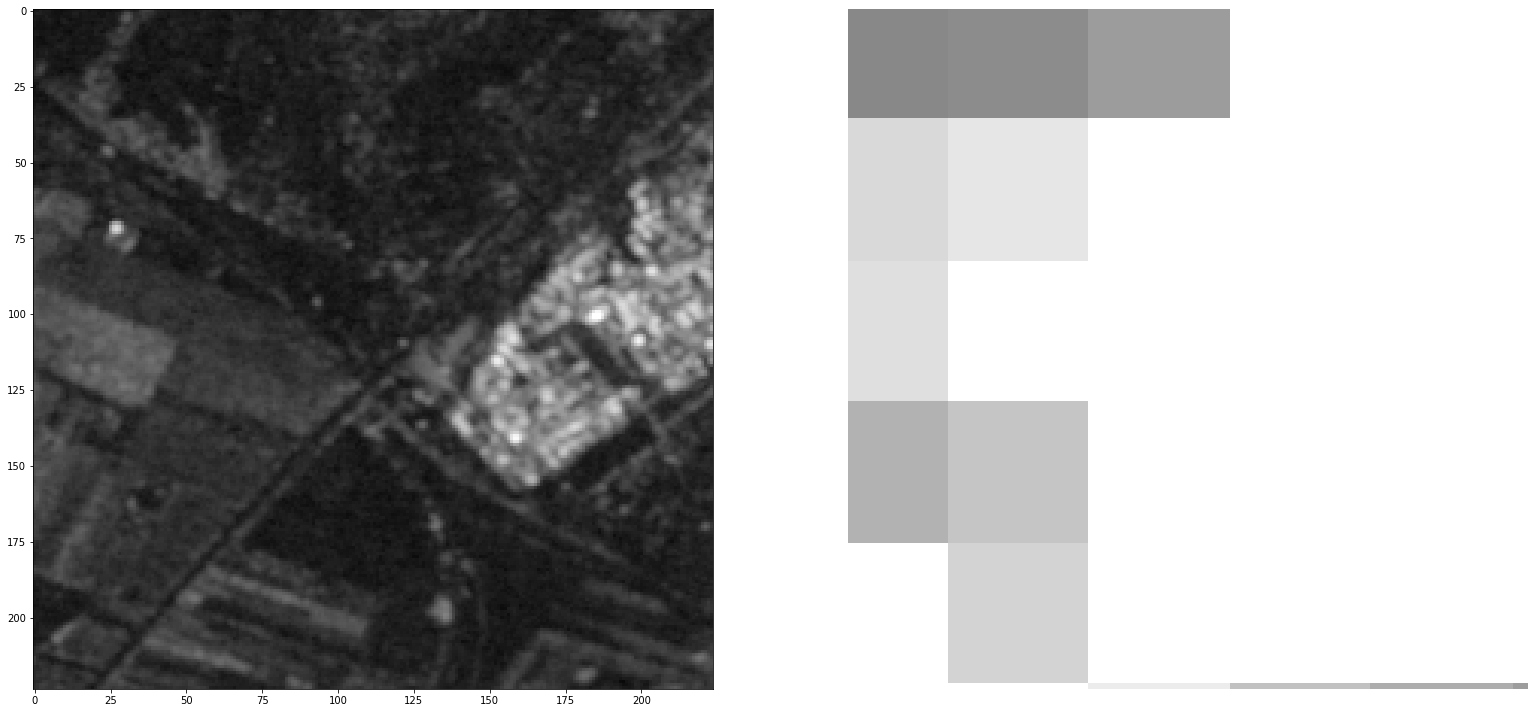

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(56, 56))
    for n in range(1):
        ax = plt.subplot(3, 4, n + 1)
        image_temp = image_batch[n]
        label_temp = label_batch[n]
        #print(label_temp.shape)
        #print(image_temp)
        #image_temp = image_temp[:3,:,:]
        #image_temp = tf.reshape(image_temp, [224, 224, 3])
        plt.imshow(X= image_temp[:,:,1],cmap='gray',vmin=-30, vmax=0)
        ax = plt.subplot(3, 4, n + 2)
        plt.imshow(X= label_temp[:,:,0],cmap='gray',vmin=0, vmax=1.8)
        plt.axis("off")

image_batch, label_batch = next(iter(train_dataset))

show_batch(image_batch.numpy(), label_batch.numpy())